In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="white")
plt.style.use('default') # fivethirtyeight, ggplot, dark_background, classic,  

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn import feature_extraction
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE

from kneed import KneeLocator
import re
import nltk
# nltk.download('stopwords') # required to be downloaded only for the first time
# nltk.download('wordnet') # required to be downloaded only for the first time
# nltk.download('omw-1.4') # required to be downloaded only for the first time
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

Fetch the data from the csv file (or DB once created and integrated with the rest of the system)

In [2]:
sp500_comp_profile_df = pd.read_csv('../data/stocks_profile.csv')
print(f'Total count of stocks in profile data: {len(sp500_comp_profile_df.ticker.unique())}')
# sp500_comp_profile_df.head()
stocks_hist_price_df = pd.read_csv('../data/stocks_hist_price.csv', date_parser=['date'])
stocks_hist_price_df.date = pd.to_datetime(stocks_hist_price_df.date, format='ISO8601')
print(f'Total count of stocks in hist price data: {len(stocks_hist_price_df.ticker.unique())}')
# stocks_hist_price_df.head()
stocks_hist_ratios_df = pd.read_csv('../data/stocks_hist_ratios.csv')
print(f'Total count of stocks in hist ratios data: {len(stocks_hist_ratios_df.ticker.unique())}') 
# stocks_hist_ratios_df.head()

Total count of stocks in profile data: 503
Total count of stocks in hist price data: 502
Total count of stocks in hist ratios data: 502


### 1. Stock Profile cleanup & pre-processing

In this section,

1. We'll do some basic EDA on the data and create some charts/plots for visual insights

2. Clean-up and restructure the data as needed

3. Use Bag of Words technique to vectorise & transform textual data into DTM features using TD-IDF values

In [3]:
# Fetch stock profile data
print(f'Shape: {sp500_comp_profile_df.shape}')
sp500_comp_profile_df.head()

Shape: (503, 9)


,ticker,company_name,sector,sub_industry,hq,date_added,cik,founded,business_desc
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902,The 3M Company is an American multinational co...
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,A. O. Smith Corporation is an American manufac...
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888,Abbott Laboratories is an American multination...
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),AbbVie is an American publicly traded biopharm...
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,Accenture plc is an Irish-domiciled multinatio...


In [4]:
# Filter out only the necessary information
filtered_stock_profiles = sp500_comp_profile_df[['ticker', 'company_name', 'sector', 'sub_industry', 'business_desc']]
# check for any NaN values
print(f'Total count of Nan values in stock profile data: {filtered_stock_profiles.isna().sum().sum()}')
filtered_stock_profiles.isna().sum()

Total count of Nan values in stock profile data: 2


ticker           0
company_name     0
sector           0
sub_industry     0
business_desc    2
dtype: int64

We observe that there are 2 missing values in business_desc column. Drop the companies whose business description data is missing, since we would need this data for clustering.

In [5]:
# drop tickers with missing values in business_desc column only
filtered_stock_profiles.dropna(axis=0, subset=['business_desc'], inplace=True)
print(f'Total stocks in consideration after dropping the ones with missing business descriptions: {filtered_stock_profiles.shape[0]}') 

Total stocks in consideration after dropping the ones with missing business descriptions: 501


In [6]:
# check dtypes
filtered_stock_profiles.dtypes

ticker           object
company_name     object
sector           object
sub_industry     object
business_desc    object
dtype: object

#### 1.1 Basic EDA and visual insights

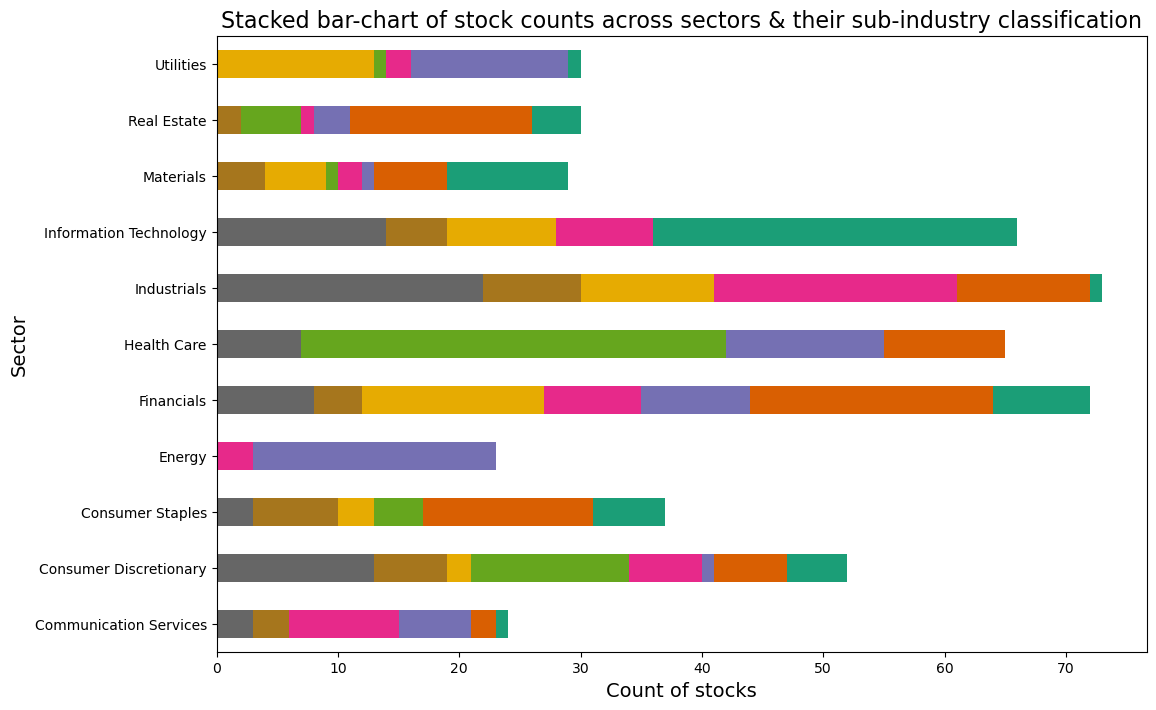

In [7]:
pd.crosstab(index=filtered_stock_profiles.sector, columns=filtered_stock_profiles['sub_industry']).plot(
    kind='barh', stacked=True, colormap=cm.Dark2_r, figsize=(12, 8), legend=None)
plt.ylabel("Sector", fontsize=14)
plt.xlabel("Count of stocks", fontsize=14)
plt.title("Stacked bar-chart of stock counts across sectors & their sub-industry classification", fontsize=16)
plt.show()

As can be observed from the above stacked barchart, Industrials, Financials, Information Technology and Health care together are 4 sectors that account for nearly half of the total number of stocks in the S&P 500 universe.

#### 1.2 Use TF-IDF method to vectorise business descriptions data

tf-idf value of a term in a document is the product of its tf and idf. The higher is the value, the more relevant the term is in that document.

In [8]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True):
    """
    Clean & preprocess input string.
    Note:   You should not set both flg_stemm & flg_lemm to be True. 
            Only one of them can be True at a time.
    """
    # clean (convert to lowercase and remove punctuations and special characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    # Tokenize (convert from string to list)
    tokens = text.split()

    # remove Stopwords
    stop_words.extend(['founded', 'firm', 'company', 'llc', 'inc', 'incorporated', 
                       'multinational', 'corporation', 'commonly', 'headquartered']) # adding more words to the default list
    if stop_words is not None:
        tokens = [word for word in tokens if word not in stop_words]
                
    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        tokens = [ps.stem(word) for word in tokens]
                
    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        tokens = [lem.lemmatize(word) for word in tokens]
            
    # back to string from list
    text = ' '.join(tokens)
    return text

In [9]:
filtered_stock_profiles['bd_clean'] = filtered_stock_profiles['business_desc'].apply(lambda x: preprocess_text(x))
filtered_stock_profiles.head()

,ticker,company_name,sector,sub_industry,business_desc,bd_clean
0,MMM,3M,Industrials,Industrial Conglomerates,The 3M Company is an American multinational co...,3m american conglomerate operating field indus...
1,AOS,A. O. Smith,Industrials,Building Products,A. O. Smith Corporation is an American manufac...,smith american manufacturer residential commer...
2,ABT,Abbott,Health Care,Health Care Equipment,Abbott Laboratories is an American multination...,abbott laboratory american medical device heal...
3,ABBV,AbbVie,Health Care,Pharmaceuticals,AbbVie is an American publicly traded biopharm...,abbvie american publicly traded biopharmaceuti...
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,Accenture plc is an Irish-domiciled multinatio...,accenture plc irishdomiciled provides consulti...


In [10]:
print(f'Total count of unique words (unigrams) found in our corpus of business descriptions across all stocks: \
      {len(set([ele for arr in list(filtered_stock_profiles["bd_clean"].apply(lambda x: str(x).split(" "))) for ele in arr]))}')

Total count of unique words (unigrams) found in our corpus of business descriptions across all stocks:       2927


In [11]:
# Tf-Idf (tuning the Tf-Idf hyperparams min_df, max_df & ngram_range)
tfidf = feature_extraction.text.TfidfVectorizer(stop_words='english', max_features=10000, min_df=2, max_df=0.4,
                                              strip_accents='unicode', ngram_range=(2,4))
tfidf_sparse = tfidf.fit_transform(filtered_stock_profiles['bd_clean'])
tfidf_sparse

<501x1172 sparse matrix of type '<class 'numpy.float64'>'
	with 3631 stored elements in Compressed Sparse Row format>

In [12]:
# let's see some features which were extracted by Tf-Idf
tfidf.get_feature_names_out()[-100:]

array(['sunnyvale california develops', 'supply chain',
       'supply equipment', 'taketwo interactive', 'technology american',
       'technology based', 'technology conglomerate', 'technology design',
       'technology industry', 'technology industry google',
       'technology industry google apple', 'technology produce',
       'technology product', 'technology provider', 'technology provides',
       'technology revenue', 'technology revenue world',
       'technology revenue world valuable', 'technology service',
       'technology specializes', 'telecommunication conglomerate',
       'telecommunication equipment', 'telephone service',
       'tempe arizona', 'texas largest', 'texas united',
       'texas united state', 'therapy treatment', 'total revenue',
       'traded airline', 'traded airline holding', 'traded real',
       'traded real estate', 'traded real estate investment',
       'trading platform', 'transportation management', 'travel fare',
       'travel fare aggr

Text(0.5, 1.0, 'Sparse Matrix Sample')

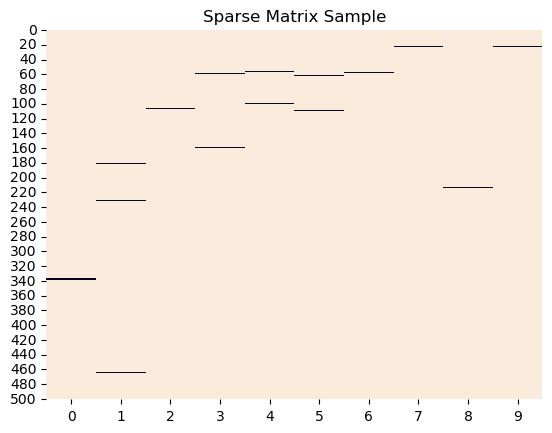

In [13]:
# visualise how sparse the matrix is
sns.heatmap(tfidf_sparse.todense()[:,np.random.randint(0,tfidf_sparse.shape[1],10)]==0, vmin=0, vmax=1, cbar=False)\
    .set_title('Sparse Matrix Sample')

#### 1.3 Apply LSA to reduce dimensionality of a sparse matrix and get a dense matrix

The above heatmap describes the sparseness of the feature matrix. We take a random sample of size 10 (features) from the feature matrix (non-zero values in black). It's pretty evident from the above figure that the matrix is extremely sparsely populated and thus holds very little informational significance and yet is highly compute intensive. Hence, there are high chances that these features will be given very low importance when combined with other dense features like financial ratios or price returns data for stock clustering.

In order to reduce the matrix dimensionality & computational complexity, we can carry out some Feature Selection, the process of selecting a subset of relevant variables. This can be done by using a method called Latent Semantic Analysis (LSA), which builds on TF-IDF method to discover a latent dimension that relates the document & word dimensions of a document-term matrix (DTM). This latent dimension is referred to as a set of themes (or topics) that focus on uncovering the semantic relation between words. 

LSA tries to extract these latent dimensions using a Machine Learning algorithm called Singular Value Decomposition (SVD), which is essentially a matrix factorisation technique that decomposes the large sparse matrix into three different matrices: orthogonal column matrix (document-aspect), orthogonal row matrix (word-aspect), & a singular matrix. Thus, from a sparse DTM, we get a dense document-aspect matrix that can be used for document clustering.

Note: Document here refers to individual stocks as represented by their textual business descriptions.

In [14]:
# define a desired n_components (themes/topics) for a Truncated SVD model
lsa_obj = TruncatedSVD(n_components=100, n_iter=100, random_state=1500)

# define tfidf sparse matrix as a DF
tfidf_sparse_df = pd.DataFrame(data=tfidf_sparse.toarray(), index=filtered_stock_profiles.ticker, columns=tfidf.get_feature_names_out())

# compute document-topic matrix
document_topic_m = lsa_obj.fit_transform(tfidf_sparse_df)
# compute word-topic matrix
word_topic_m = lsa_obj.components_.T
# compute singular topic matrix
sing_topic_m = lsa_obj.singular_values_

print(f'document_topic_m.shape: {document_topic_m.shape}')
print(f'word_topic_m.shape: {word_topic_m.shape}')
print(f'sing_topic_m.shape: {sing_topic_m.shape}')

# define topics
topics = [f'Topic_{i}' for i in range(0, sing_topic_m.shape[0])]
document_topic_df = pd.DataFrame(data=document_topic_m, index=filtered_stock_profiles.ticker, columns=topics)
word_topic_df = pd.DataFrame(data=word_topic_m, index=tfidf_sparse_df.columns, columns=topics)
sing_topic_df = pd.DataFrame(data=sing_topic_m, index=topics)


document_topic_m.shape: (501, 100)
word_topic_m.shape: (1172, 100)
sing_topic_m.shape: (100,)


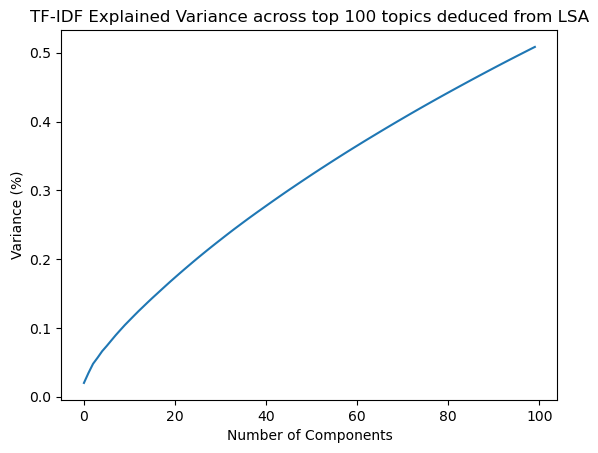

In [15]:
# Plotting the Cumulative Summation of the Explained Variance
plt.plot(np.cumsum(lsa_obj.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title(f'TF-IDF Explained Variance across top {lsa_obj.explained_variance_ratio_.shape[0]} topics deduced from LSA')
plt.show()

We can observe that almost 50% of the variance in the descriptions data is being explained by just top 100 topics (latent dimensions). This is a significant reduction from the earlier 1000+ dimensional sparse dataset. So, we'll proceed with considering the top 100 topics obtained by the SVD model for clustering stocks (along with the historical financial ratios).

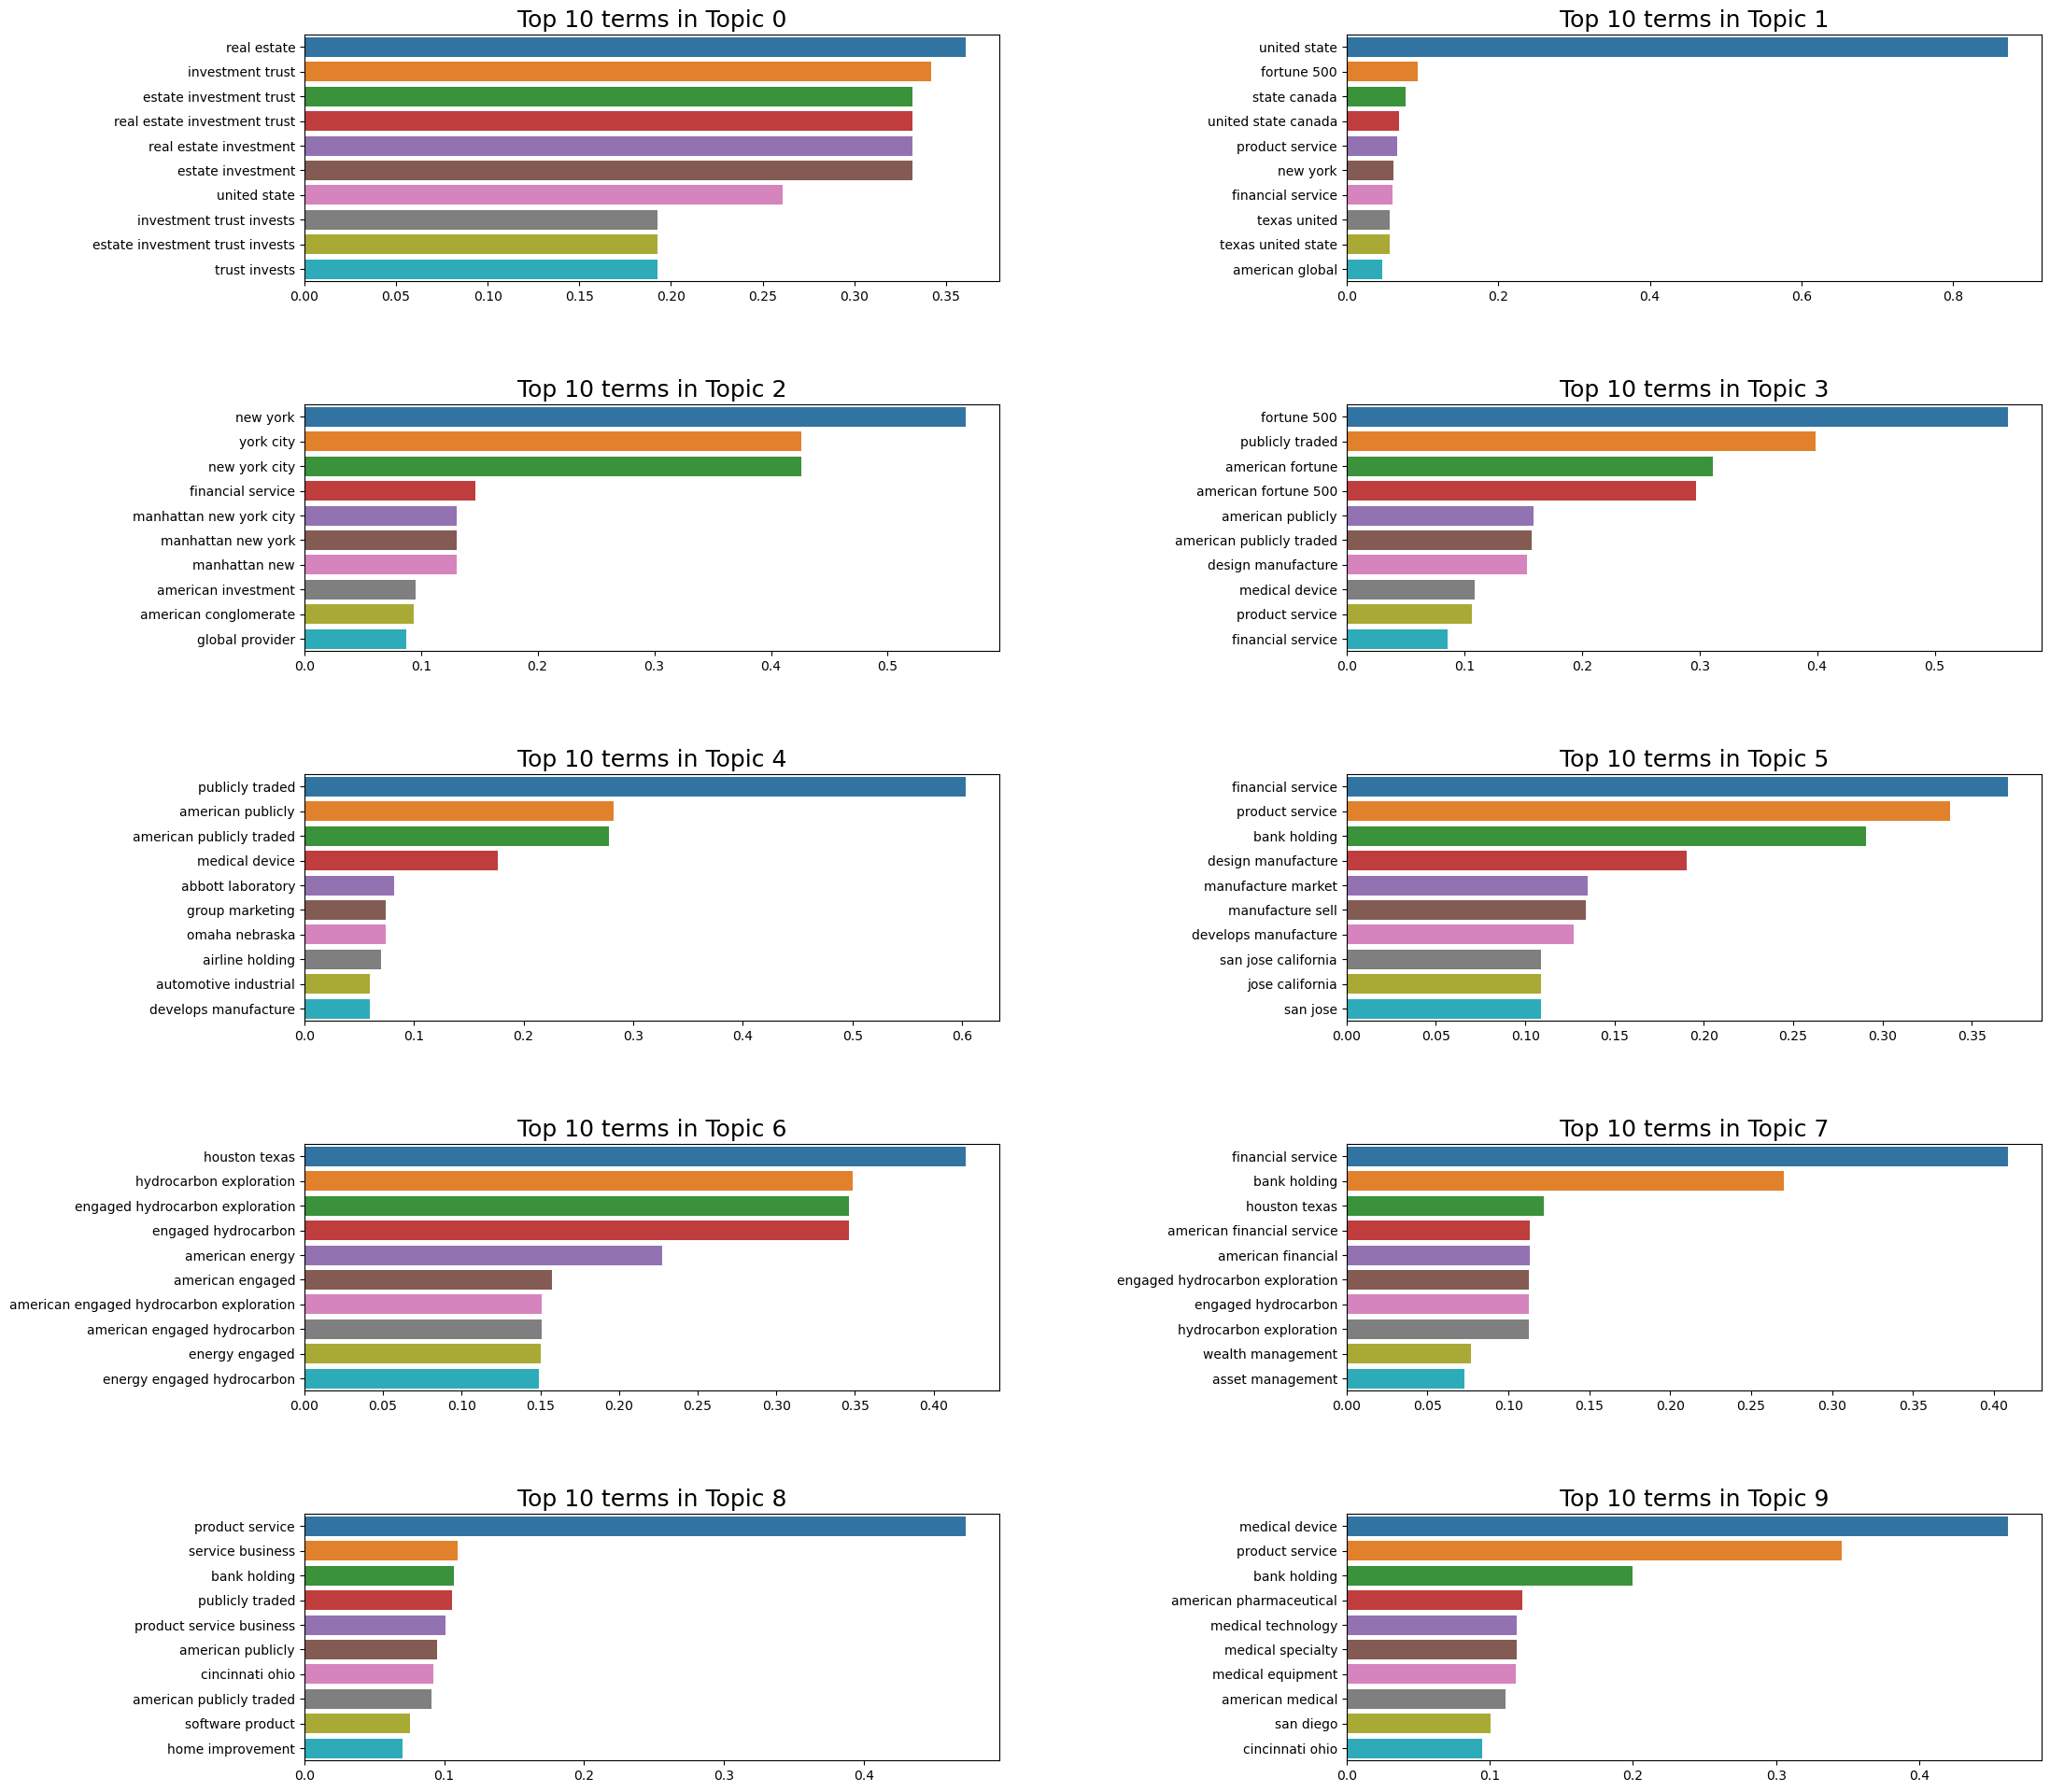

In [16]:
# Plot the top 10 words within each topic/theme
fig1 = plt.figure(figsize=(24, 24))
fig1.subplots_adjust(hspace=.5, wspace=.5)
plt.clf()

for i in range(0, 10):
    fig1.add_subplot(5, 2, i+1)
    temp = word_topic_df.iloc[:, i]
    temp = temp.sort_values(ascending=False)
    plt.title(f'Top 10 terms in Topic {i}', fontsize=18)
    sns.barplot(x= temp.iloc[:10].values, y=temp.iloc[:10].index)
    i += 1

plt.show()

In [17]:
# fetch the condensed dense document-aspect DF
document_topic_df.head()
final_dense_df = document_topic_df.drop(axis=0, index='IR') # drop as we don't have hist price data for ticker='IR' & the next clustering function will throw an error 

---

### 2. Clustering

#### 2.1 OPTICS

In [18]:
def plot_TSNE(data, labels):
    """
    Plot the results of the TSNE algorithm to visualise the 
    cluster densities
    """
    # all stock with its cluster label (including -1)
    clustered_series_all = pd.Series(index=data.index, data=labels)
    # with only actual clusters 
    clustered_series = clustered_series_all[clustered_series_all != -1]

    # to plot multidimension into 2D
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(data)

    plt.figure(1, facecolor='white', figsize=(8,6))
    plt.clf()
    plt.axis('off')

    # clustered
    clst_plot = plt.scatter(
    X_tsne[(clustered_series_all!=-1).values, 0],
    X_tsne[(clustered_series_all!=-1).values, 1],
    s=100, alpha=0.9, c=labels[labels!=-1], cmap=cm.Paired_r, marker='*')
    # unclustered in the background
    plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100, alpha=0.05)

    handles, _ = clst_plot.legend_elements(prop='colors')
    plt.legend(handles, clustered_series.value_counts().index)
    plt.title('T-SNE of all Stocks with Clusters Noted')
    plt.show()

    return clustered_series_all


# show number of stocks in each cluster 
def plot_cluster_counts(labels_df):
    """
    Plot cluster counts histogram bar chart
    """
    plt.figure(figsize=(8,6))
    plt.barh(
    range(len(labels_df[labels_df!=-1].value_counts())), labels_df[labels_df!=-1].value_counts())
    plt.title('Cluster Member Counts')
    plt.xlabel('Stocks in Cluster')
    plt.ylabel('Cluster Number')
    plt.show()

# plot price movements for cluster members
def plot_cluster_members(labels_df):
    """
    Plot the cluster members' log prices
    to observe if they follow a similar path 
    """
    # get the number of stocks in each cluster 
    counts = labels_df[labels_df!=-1].value_counts()

    # let's visualize some clusters
    cluster_vis_list = list(counts[counts>1].index)[::-1]

    sf = stocks_hist_price_df.pivot_table(values='Adj Close', index='date', columns='ticker')

    # plot a handful of the smallest clusters
    for clust in cluster_vis_list[0:min(len(cluster_vis_list), 4)]: 
        tickers = list(labels_df[labels_df==clust].index) 
        means = np.log(sf.loc[:dt.datetime(2018, 12, 31), tickers].mean())
        data = np.log(sf.loc[:dt.datetime(2018, 12, 31), tickers]).sub(means) 
        data.plot(title='Stock Time Series for Cluster %d' % clust)
        plt.show()

Running the OPTICS model
----------------------------------------------------------------------------------------------------
max_eps: inf
min_samples: 4
model fit params: {'algorithm': 'auto', 'cluster_method': 'xi', 'eps': None, 'leaf_size': 30, 'max_eps': inf, 'memory': None, 'metric': 'minkowski', 'metric_params': None, 'min_cluster_size': None, 'min_samples': 4, 'n_jobs': None, 'p': 2, 'predecessor_correction': True, 'xi': 0.05}

db.cluster_hierarchy_: 
[[  1  23]
 [104 107]
 [116 122]
 [123 129]
 [116 132]
 [142 145]
 [169 173]
 [174 178]
 [211 214]
 [260 263]
 [268 271]
 [305 309]
 [316 319]
 [320 324]
 [331 334]
 [364 367]
 [386 390]
 [404 409]
 [411 414]
 [417 423]
 [430 433]
 [442 445]
 [460 463]
 [471 474]
 [  0 499]]


The Silhouette Score for our OPTICS model fit on preprocessed ratios data : -0.0978636429943914

The Calinski Harabasz Score for our OPTICS model fit on preprocessed ratios data : 5.611506836725805
-------------------------------------------------------------

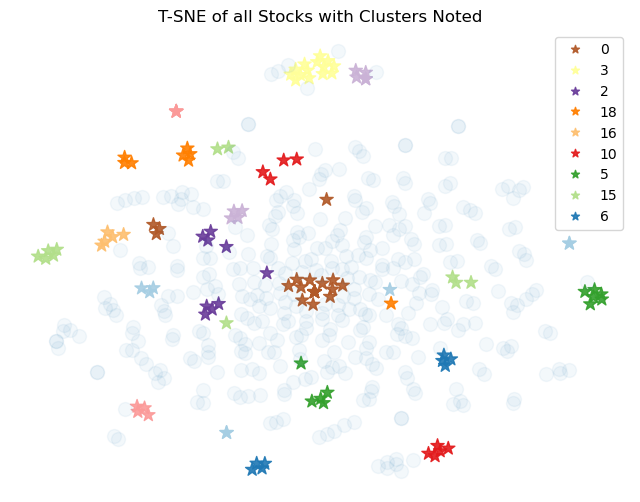

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster counts bar chart



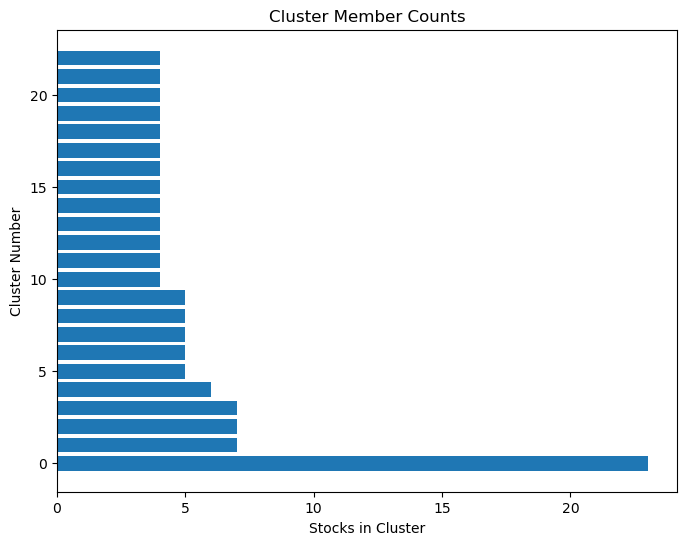

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster member price movements: sample plots of 4 least dense clusters



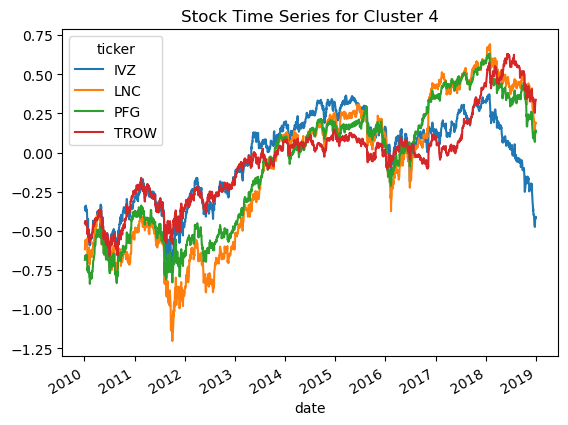

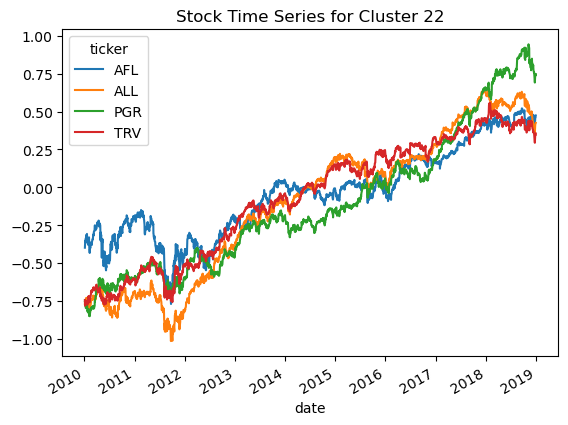

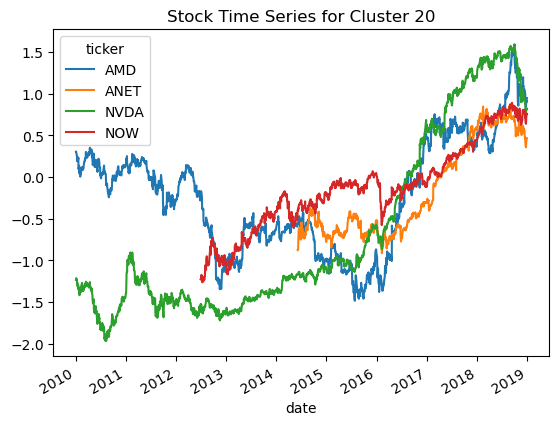

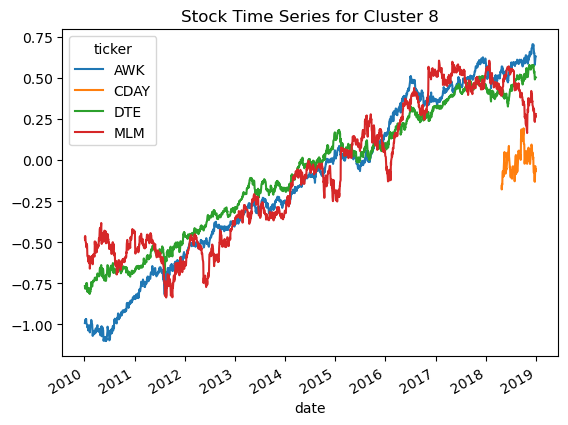

In [19]:
def optics_plots(data, max_eps: float=np.inf, min_samples: int=5):
    """
    Fit OPTICS clustering algorithm over the data;
    Plot all charts for the model predictions 
    """
    print('Running the OPTICS model')
    print('--'*50)
    print(f'max_eps: {max_eps}\nmin_samples: {min_samples}')
    db = OPTICS(max_eps=max_eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    print(f'model fit params: {db.get_params()}\n')
    print(f'db.cluster_hierarchy_: \n{db.cluster_hierarchy_}\n')

    # Compute Silouette score
    sil_score = silhouette_score(data, labels=labels, random_state=1500)
    print(f'\nThe Silhouette Score for our OPTICS model fit on preprocessed ratios data : {sil_score}')

    cal_hb_score = calinski_harabasz_score(data, labels=labels)
    print(f'\nThe Calinski Harabasz Score for our OPTICS model fit on preprocessed ratios data : {cal_hb_score}')

    # TSNE
    print('--'*100)
    print('TSNE plot for the model\n')
    labels_df = plot_TSNE(data, labels)

    # plot cluster count (bar chart)
    print('--'*100)
    print('Cluster counts bar chart\n')
    plot_cluster_counts(labels_df)

    # plot cluster members
    print('--'*100)
    print('Cluster member price movements: sample plots of 4 least dense clusters\n')
    plot_cluster_members(labels_df)

    # print('Running the DBSCAN model\n')
    # print(f'K: {k}')
    # preds = KMeans(n_clusters=k, init='random', random_state=1500, max_iter=20000, n_init=10).fit_predict(data)
    # # print(f'eps: {eps}\nmin_samples: {min_samples}')
    # # preds = DBSCAN(min_samples=min_samples, eps=eps).fit_predict(data)

    # # TSNE
    # print('\n------------------------------------\n')
    # print('TSNE plot for the model\n')
    # labels_df = plot_TSNE(data, preds)

    # # plot cluster count (bar chart)
    # print('\n------------------------------------\n')
    # print('Cluster counts bar chart\n')
    # plot_cluster_counts(labels_df)

    # # plot cluster members
    # print('\n------------------------------------\n')
    # print('Cluster member price movements: sample plots of 4 least dense clusters\n')
    # plot_cluster_members(labels_df)
    
optics_plots(final_dense_df, min_samples=4)

----

## Ignore

In [20]:
# clf = OPTICS()
# clusters_labels = clf.fit_predict(X_dense)

# n_clusters_ = len(set(clusters_labels)) - (1 if -1 in clusters_labels else 0)
# print (f"Total custers discovered: {n_clusters_}")
# clustered = clusters_labels

# clustered_series = pd.Series(index=filtered_stock_profiles.ticker, data=clustered.flatten())
# clustered_series = clustered_series[clustered_series != -1]
# plt.figure(figsize=(16, 8))
# plt.barh(
#     range(len(clustered_series.value_counts())),
#     clustered_series.value_counts(),
#     alpha=0.625
# )
# plt.title('Cluster Member Counts')
# plt.xlabel('Stocks in Cluster')

In [21]:
# fig = plt.figure(figsize=(20, 10))
# fig.subplots_adjust(hspace=.5, wspace=.2)
# i = 1

# for eps in range(10, 0, -1):
#     # eps = 1/(11-x)
#     db = DBSCAN(eps=eps, min_samples=5).fit(final_dense_df)
#     core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#     core_samples_mask[db.core_sample_indices_] = True
#     labels = db.labels_
    
#     ax = fig.add_subplot(2, 5, i)
#     ax.text(x=0.3, y=1.1, s="eps = {}".format(round(eps, 2)), fontsize=25, ha="center")
#     sns.scatterplot(x=final_dense_df.iloc[:,0], y=final_dense_df.iloc[:,1], hue=["cluster-{}".format(x) for x in labels])
    
#     i += 1